# Identifying the Sources of Winter Air Pollution in Bangkok


The main pollutant here is the small particle pollution or PM 2.5 particles. These particles are smaller than 2.5 micrometer, smaller than the size of the human hair. Because it is so small it can bypass many natural filter systems and go right into the blood steam. Many research have shown that long term exposure can be very harmful.

The government agencies are still disagree on the sources of the pollutions !


## Hypothesis:

1. The source is from local traffic. The cold winter air causes a temperature inversion effect that traps the pollution in Bangkok. This means the pollution will depends highly on the weather pattern and traffic.
2. The source is from seasonal agricultural burning. Bangkok is not an agricultural region, so it is unclear how much burning is going to affect Bangkok. 


## Analysis Procedures<a id='tbc'></a>

1. Data: 
    - weather data scrape from weather underground
    - PM2.5 data from Berkeley Earth project
    - fire spots from NASA 
    - traffic index from Longdo Traffic (traffic report for Bangkok).
    

2. Data Visualization and feature engineer:
    1. [Visualize PM2.5 data](#vispm)
    2. [Visualize fire spots, and feature engineer](#fire)
    3. [Relationship with weather](#weather)
    4. [Relationship with traffic index, clean up the data](#traffic) 
    

3. [Build a machine learning model](#ML) 
    - Extremely Randomized Trees
    - Train test split
    - Hyper parameter tuning
    - Identify the air pollution sources using feature of importance 
    
    
4. [Model Interpretation](#inter): use tree interpreter to visualize the contribution of each feature for specific cases

# Boilerplate section

In [1]:
# import the library
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold

from IPython.display import display
import matplotlib.dates as mdates
import seaborn as sns

from bokeh.io import output_file, output_notebook, show,curdoc, reset_output,export_png
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, CategoricalColorMapper, Slider, DateRangeSlider,
    DateSlider, SingleIntervalTicker, LinearAxis,Legend, LegendItem, Label
)
from bokeh.models.markers import Asterisk
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import STAMEN_TERRAIN,CARTODBPOSITRON_RETINA
from bokeh.layouts import widgetbox,row, column, gridplot

output_notebook()

Loading BokehJS ...

In [10]:
#print score print out rmse, and r2 score
def print_score(m,Xtrn=X_trn,ytrn=y_trn,Xval=X_val,yval=y_val):
    res = [mean_squared_error(m.predict(Xtrn), ytrn),
           mean_squared_error(m.predict(Xval), yval), 
           m.score(Xtrn, ytrn),
           m.score(Xval, yval)]
    # if rf has bagging, print the oob score, also
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    #print('Training loss \t Val loss \t Train R2 \t Val R2')
    print(res)
    return res

In [23]:
def plot_score(m,res,val=False):
    
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    if val:
        x = ['train','val','test']
        c = ['royalblue','orange','red']
        res = np.insert(res,2,mean_squared_error(m.predict(X_test),y_test))
        res = np.append(res,m.score(X_test,y_test))
        print(res)
    else:
        x = ['train', 'test']
        c = ['royalblue','red']

    ax[0].bar(x=x, height=res[:len(x)],width=0.5,edgecolor ='black',color =c)
    ax[0].set_title('RMSE loss')
    
    for i in range(len(x)):
        ax[0].text(s=f'{res[i].round(2)}',x=i, y=res[i].round(2)*0.7,horizontalalignment='center')
  
    ax[1].bar(x=x, height=res[len(x):],width=0.5,edgecolor ='black',color =c)
    ax[1].set_title('R2 Score')
    
    for i in range(len(x)):
        ax[1].text(s=f'{res[len(x)+i].round(2)}',x=i, y=res[len(x)+i].round(2)*0.7,horizontalalignment='center')
    

# A.Visualize PM2.5 data<a id='vispm'></a>

Visualize the PM2.5 particles and it relationship seasons and time.

In [89]:
#load the PM2.5 data for bkk and change time columne to datetime index
#load the pollution data
pm25_all = pd.read_csv('data/model/pm25bkknear_proc.csv')
pm25_all['datetime'] = pd.to_datetime(pm25_all['Time'])
pm25_all = pm25_all.drop('Time',axis=1)
pm25_all = pm25_all.set_index('datetime')

# select Bangkok
bkkpm = pm25_all.loc[pm25_all['Region'] == 'Bangkok'].copy()

In [90]:
# generate season group 
bkkpm['season'] = 'other\nseasons'
bkkpm.loc['2016-09':'2017-05','season'] = 'winter\n2016-2017'
bkkpm.loc['2017-09':'2018-05','season'] = 'winter\n2017-2018'
bkkpm.loc['2018-09':'2019-05','season'] = 'winter\n2018-2019'

(736026.625, 737138.8333333334)

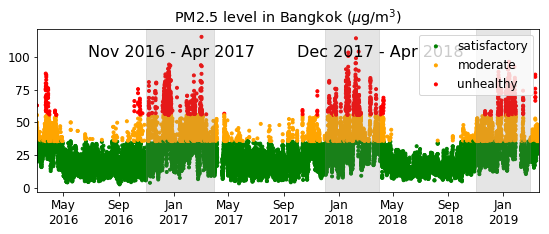

In [268]:
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(111)

# make legend and plot each level at a time 
# Each level has to be plotted separtely to generate proper legend
for legend in ['satisfactory', 'moderate', 'unhealthy']:
    temp = bkkpm[bkkpm['level']==legend]
    # plot the data for each pollution level
    ax1.scatter(temp.index, temp['PM2.5'], 
                c=temp['color'], marker='.', label=legend)

plt.legend(loc='upper right')
plt.title("PM2.5 level in Bangkok ($\mu$g/m$^3$)")

# add vertical spand adnotation 
ax1.axvspan('2016-11','2017-04', color='gray', alpha=0.2)
plt.text('2017-01', 100, r'Nov 2016 - Apr 2017 ',
         {'color': 'k', 'fontsize': 16, 'ha': 'center'})

# add vertical spand adnotation
ax1.axvspan('2017-12','2018-04', color='gray', alpha=0.2)
plt.text('2017-10', 100, r'Dec 2017 - Apr 2018 ',
         {'color': 'k', 'fontsize': 16, 'ha': 'left'})
# add vertical spand adnotation
ax1.axvspan('2018-11','2019-03', color='gray', alpha=0.2)
# format the top plot xaxis tick style
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
plt.xlim(bkkpm.index.min(), bkkpm.index.max())


Hourly record, start in March 2016.  The pollution level are divided into three category: satisfactory, moderate and unhealthy. Seasonal pattern can be seen. High pollution periods are in winter.


## Partial Autocorrelation

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot

Text(5, 0.8, '1 hour lag')

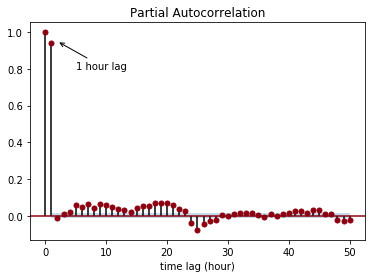

In [72]:
plot_pacf(bkkpm['PM2.5'], lags=50,color='xkcd:crimson')
plt.xlabel('time lag (hour)')
plt.annotate('1 hour lag',xy=(2,0.95),xytext=(5,0.8), arrowprops=dict(arrowstyle="->"))

Because the particle pollution tend to linger in the atmosphere, the current value will depend on the previous value. This means that the previous level must be included in the model, but from how far back?  Using PACF suggests using the data with lag one hour, so the level with lag one is included in the model. 

[go to Table of Content](#tbc)

# B.Visualize fire spots, and relationship with the pollution level<a id='fire'></a>

In [109]:
fire = pd.read_csv('data/model/thfire.csv')
fire = fire.drop(['latitude','longitude'],axis=1)
fire['datetime'] = pd.to_datetime(fire['datetime'])
fire.set_index('datetime',inplace=True)

# load the regional information with latitude and longitude information in 
# mercadian coordinate
region_df = pd.read_csv('data/model/region_info.csv',sep=';')

In [768]:
fire.head()

,brightness,acq_date,power,x_mer,y_mer,dis2BKK
datetime,,,,,,
2016-01-01 10:42:00,313.1,2016-01-01,5.4,1.164407e+07,1.865610e+06,557700.429616
2016-01-01 10:42:00,317.0,2016-01-01,8.6,1.167415e+07,1.934536e+06,623167.037895
2016-01-01 10:42:00,318.0,2016-01-01,9.8,1.116164e+07,1.923257e+06,379190.307905
2016-01-01 10:42:00,327.3,2016-01-01,26.5,1.116316e+07,1.923060e+06,378891.882049
2016-01-01 10:42:00,320.0,2016-01-01,9.2,1.146312e+07,1.918268e+06,463870.543894


In [33]:
[[bkk_x, bkk_y]]= region_df.query('City == "Bangkok"')[['x_mer','y_mer']].values
stepx = 3.5E5
stepy = 1*stepx

In [41]:
day3 = '2018-01-08' 
day = '2018-02-08'

# define the map size the map is in meter unit 
p = figure(x_range=(bkk_x-stepx, bkk_x+stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
               x_axis_type="mercator", y_axis_type="mercator", 
               title='Fire Map 2018', plot_width=500, plot_height=500,
           toolbar_location=None)
# add terrian map
p.add_tile(STAMEN_TERRAIN)

# add 10 kmline
p.line(x=[bkk_x + 0.1*stepx, bkk_x + 0.1*stepx +100E3] , y= [bkk_y - 0.7*stepy,bkk_y - 0.7*stepy],
      color='black',line_width=2)
# add 10 km text
kmline = Label(x=bkk_x + 0.15*stepx, y=bkk_y - 0.7*stepy,
                 text='100 km')
p.add_layout(kmline)

# add 240 km circle
p.circle(x=bkk_x,y=bkk_y, size=300, color='yellow', alpha=0.3)

#  Bangkok location          
glyph = Asterisk(x=bkk_x,y=bkk_y, size=20, line_color='darkblue')
p.add_glyph(glyph) 

# Data on 8 Feb
source = ColumnDataSource(fire[day])
p.triangle(source=source,x='x_mer',y='y_mer', size=4, color='red',
           legend='8 Feb 2018 with PM2.5 unhealthy')

# Data on 8 Jan
source = ColumnDataSource(fire[day3])
p.triangle(source=source,x='x_mer',y='y_mer', size=4, color='green',
           legend='8 Jan 2018 with PM2.5 satisfactory')

p.legend.location = "bottom_left"

show(p)

This map shows first spots on two days: Jan 8 in green and Feb 8 2018 in red. Jan 8 is a good air, and we can see that the number of fire spot is much less then on Feb 8.

![title](blog2/firemap2018.png)

### Fire Map feature Engineer 

1. The average wind speed is 10 km/hour
2. The PM2.5 is defined as the rolling average over 24 hours. This give 240 km.
3. Create a time lag based on the distance from Bangkok use that as the time for the fire 
4. Count fire spots in the past 24 hours for 3 zones: 0 - 240 km, 240 - 480km, and 480 - 720 km.


In [110]:
# shift the data based on the distance from Bangkok 
fire['newtime'] = fire.index + pd.to_timedelta((fire['dis2BKK']/1e4).round(),unit='hours')
fire['newtime'] = fire['newtime'].dt.round('H')
fire = fire.set_index('newtime')

**0 - 240 km zone**

In [111]:
# find active fire with in 240 km from bkk 
fireclose240 = fire[fire['dis2BKK'].values < 240000]
# count the number of hotspot by hour 
fireclose240 = fireclose240.resample('H').agg({'power':['count']})
fireclose240.columns = ['fire0-240km']
# collect the amount of fire in the past 24 hours 
fireclose240['fire0-240km'] = fireclose240['fire0-240km'].rolling(window=24).sum().dropna()

**240km - 480 km zone**

In [112]:
# find active fire with in 240-480 km from bkk 
fireclose480 = fire.query('240000 < dis2BKK < 480000')
fireclose480 = fireclose480.resample('H').agg({'power':['count']})
fireclose480.columns = ['fire240km-480km']
fireclose480['fire240km-480km'] =fireclose480['fire240km-480km'].rolling(window=24).sum().dropna()

**480km - 720 km zone**

In [113]:
# find active fire with in 480-720 km from bkk 
fireclose720 = fire.query('240000 < dis2BKK < 480000')
fireclose720 = fireclose720.resample('H').agg({'power':['count']}).rolling(window=24).sum().dropna()
fireclose720.columns = ['fire480km-720km']
fireclose720['fire480km-720km'] = fireclose720['fire480km-720km'].rolling(window=24).sum().dropna()

In [114]:
# merge all fire df 
firehourlyrollall = fireclose240.merge(fireclose480,left_index=True,
                                    right_index=True, how='right')

firehourlyrollall = firehourlyrollall.merge(fireclose720,left_index=True,
                                    right_index=True, how='right')

firehourlyrollall = firehourlyrollall.dropna().astype(int)

In [115]:
pm_fire = firehourlyrollall.merge(bkkpm['PM2.5'],left_index=True,
                                    right_index=True, how='left' )

### Seasonal Agricultural Burning 

Text(2018-12, 800, '')

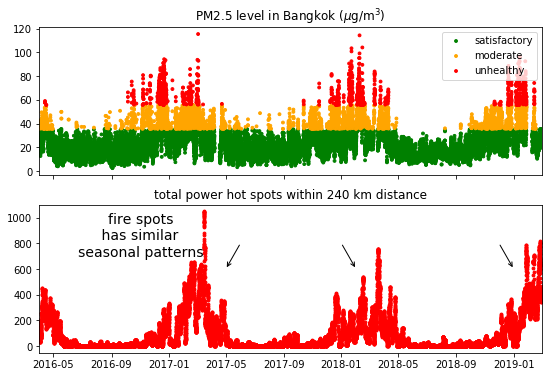

In [90]:
import matplotlib.dates as mdates

temp = pm_fire['2016-04':'2019-02'].copy()
temp['color'] = pd.cut(temp['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'])
temp['level'] = pd.cut(temp['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate', 'unhealthy'])

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(9, 6),sharex=True)

# make legend 
for legend in ['satisfactory', 'moderate', 'unhealthy']:
    toplot = temp[temp['level']==legend]
    # plot the data for each pollution level
    ax1.scatter(toplot.index, toplot['PM2.5'], 
                c=toplot['color'],s=8, label=legend)
    
ax1.legend(loc='upper right')
ax1.set_title("PM2.5 level in Bangkok ($\mu$g/m$^3$)")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))

ax2.scatter(x=temp.index,y=temp['fire0-240km'],s=8,c='red')
ax2.set_title("total power hot spots within 240 km distance")
plt.xlim(temp.index.min(), temp.index.max())

ax2.text('2016-11', 700, 'fire spots\n has similar \nseasonal patterns',
         {'color': 'k', 'fontsize': 14, 'ha': 'center'})
ax2.annotate("", xy=('2017-05',600),xytext=('2017-06',800),arrowprops=dict(arrowstyle="->"))
ax2.annotate("", xy=('2018-02',600),xytext=('2018-01',800),arrowprops=dict(arrowstyle="->"))
ax2.annotate("", xy=('2019-01',600),xytext=('2018-12',800),arrowprops=dict(arrowstyle="->"))


In [116]:
cols = ['fire0-240km', 'fire240km-480km', 'fire480km-720km']
newcols = []
for col in cols:
    newcol = 'log(1+'+col +')'
    pm_fire[newcol] = np.log(1 + pm_fire[col])
    newcols.append(newcol)

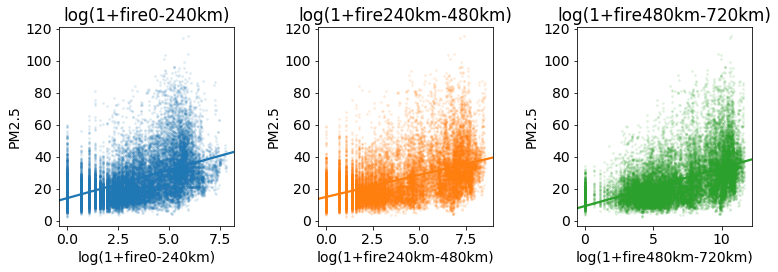

In [123]:
fig,axs = plt.subplots(1,3,figsize=(11,4))
axs = axs.reshape(-1)
for i, col in enumerate(newcols):
    sns.regplot(data=pm_fire,x=col,y='PM2.5',ax=axs[i],scatter_kws={'alpha':0.1,'s':3})
    axs[i].set_title(col)
    plt.close(2)
plt.tight_layout()

The number of fire spots has logarithmic relationship with the pollution level.

[go to Table of Content](#tbc)

# C.Relationship with weather<a id='weather'></a>

In [91]:
# Load the data
weather = pd.read_csv('data/model/weatherall.csv').dropna()
weather['date'] = pd.to_datetime(weather['date'])
weather = weather.set_index('date').sort_index()

# look at difference between winter and not winter
weather['is_winter'] = 'other'
weather.loc[np.isin(weather.index.month, [12, 1, 2]), 'is_winter'] = 'winter'
weather[['Wind', 'Condition', 'is_winter', 'is_rain', 'is_fair',
         'is_cloudy', 'is_fog', 'is_windy', 'is_calm']] = weather[['Wind', 'Condition', 'is_winter', 'is_rain', 'is_fair', 'is_cloudy', 'is_fog', 'is_windy', 'is_calm']].astype('category')

# merge with weather data by datetime
pm_weather = weather.merge(bkkpm['PM2.5'],how='right',left_index=True,right_index=True)
pm_weather = pm_weather.sort_index()
pm_weather.drop('Dew Point(C)',axis=1,inplace=True)

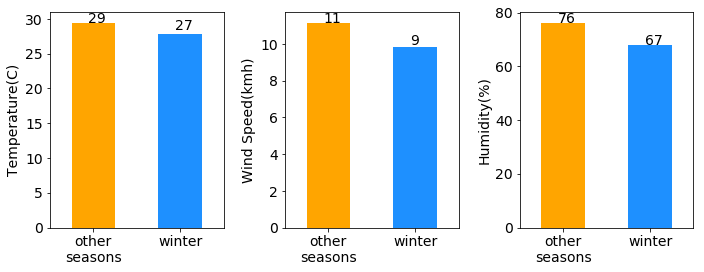

In [116]:
#set plt font size
plt.rcParams.update({'font.size': 14})

# explore difference between winter and other season
season = weather[['Temperature(C)','Wind Speed(kmh)','Humidity(%)',
         'is_winter']].groupby('is_winter',as_index=False).mean()

season = pd.melt(season,id_vars='is_winter')

# set plot parameter
barwidth = 0.9
colors = ['orange','dodgerblue']

#plot temperature
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
data= season[season['variable']=='Temperature(C)']
data.plot(x='variable',y='value', kind='bar',ax=ax1, color=colors, legend=None)
ax1.set_xticklabels(['other\nseasons','winter'],rotation=0)
plt.xlabel('')
plt.ylabel('Temperature(C)')

# create bar addnotation
barlabels = data.value.values.astype(int).astype(str)
xys = [(0.22,0.95), (0.72,0.92)]
# Text on the top of each barplot
plt.annotate(barlabels[0],xycoords='axes fraction',xy = xys[0],
            textcoords='axes fraction', xytext= xys[0])
plt.annotate(barlabels[1],xycoords='axes fraction',xy = xys[1],
            textcoords='axes fraction', xytext= xys[1])

# plot wind speed 
ax2 = fig.add_subplot(132)
data= season[season['variable']=='Wind Speed(kmh)']
data.plot(x='variable',y='value', kind='bar',ax=ax2, color=colors, legend=None)
ax2.set_xticklabels(['other\nseasons','winter'],rotation=0)
plt.xlabel('')
plt.ylabel('Wind Speed(kmh)')

# create bar addnotation
barlabels = data.value.values.astype(int).astype(str)
xys = [(0.22,0.95), (0.72,0.85)]
# Text on the top of each barplot
plt.annotate(barlabels[0],xycoords='axes fraction',xy = xys[0],
            textcoords='axes fraction', xytext= xys[0])
plt.annotate(barlabels[1],xycoords='axes fraction',xy = xys[1],
            textcoords='axes fraction', xytext= xys[1])

# plot humidity
ax3 = fig.add_subplot(133)
data= season[season['variable']=='Humidity(%)']
data.plot(x='variable',y='value', kind='bar',ax=ax3, color=colors, legend=None)
ax3.set_xticklabels(['other\nseasons','winter'],rotation=0)
plt.xlabel('')
plt.ylabel('Humidity(%)')

# create bar addnotation
barlabels = data.value.values.astype(int).astype(str)
xys = [(0.22,0.95), (0.72,0.85)]
# Text on the top of each barplot
plt.annotate(barlabels[0],xycoords='axes fraction',xy = xys[0],
            textcoords='axes fraction', xytext= xys[0])
plt.annotate(barlabels[1],xycoords='axes fraction',xy = xys[1],
            textcoords='axes fraction', xytext= xys[1])

plt.tight_layout()

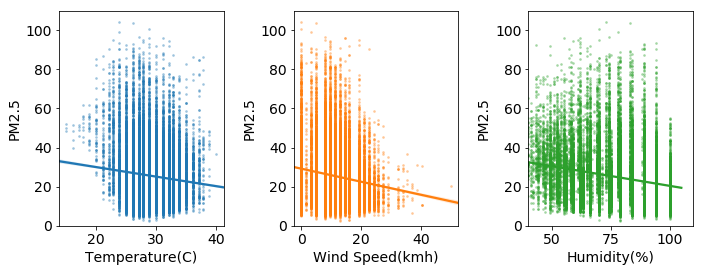

In [93]:
#set plt font size
plt.rcParams.update({'font.size': 14})

# explore relationship with PM2.5
data = pm_weather.copy()
fig, ax = plt.subplots(1,3,figsize=(10,4))
ax = ax.flat
cols = ['Temperature(C)', 'Wind Speed(kmh)','Humidity(%)']
for i,col  in enumerate(cols):
    sns.regplot(data=data, x= col,y='PM2.5',ax=ax[i],scatter_kws={'alpha':0.3,'s':3})
    ax[i].axes.set_ylim([0,110]) 

ax[2].axes.set_xlim([40,110])

plt.tight_layout()

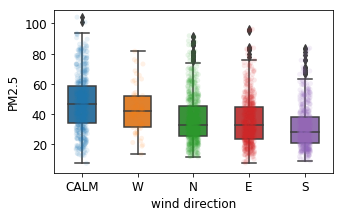

In [121]:
#set plt font size
plt.rcParams.update({'font.size': 12})

fig,ax = plt.subplots(figsize=(5,3))

# plot wind direction relationship with pm2.5
# select the data in winter
data = pm_weather.query('is_winter == "winter"')
# reduce the number of categories to simplify the plot
data = data[data['Wind'].isin(['CALM','N','W','E','S'])]

# sort the data by the mean pollution value
temp = data[['PM2.5','Wind']].groupby('Wind').agg(['mean','median','std']).dropna()
temp.columns = ['mean','median','std']
temp = temp.sort_values('median',ascending=False)
temp.head()

con ='Wind'
sns.catplot(data=data, x= con, y='PM2.5',alpha=0.1,order=temp.index,ax=ax) 
sns.boxplot(data=data, x=con, y='PM2.5',order=temp.index,width=0.5,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.axes.set_xlabel('wind direction')
plt.close(2)
#plt.title('winter wind')

'Temperature(C)', 'Humidity(%)', 'Wind Speed(kmh)', 'is_rain', 'is_calm', and 'Wind' (direction) columns are all relevant.

[go to Table of Content](#tbc)

# D.Relationship with traffic index, clean up the data<a id='traffic'></a>

The raw data has some mistake on the date. The have some input on 2019/12/30, which is supposed to be 2018/12/30. This was fixed by hand. Some data is missing. This is fixed using the average of the same day and hour but different year. 

In [95]:
traffic_old = pd.read_csv('data/model/trafficindex.csv').drop('timestamp',axis=1)
traffic_old['datetime'] = pd.to_datetime(traffic_old['datetime'])

traffic_old = traffic_old.set_index('datetime').resample('H').mean().round(1)

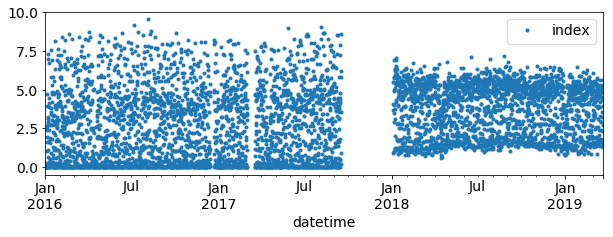

In [108]:
traffic_old['2016':'2019'].resample('5h').mean().plot(alpha=1,marker='.',figsize=(10,3),linestyle='None')

In [892]:
# create the avarage value data frame 
traffic_old['dayofyear'] = traffic_old.index.dayofyear
traffic_old['hour'] = traffic_old.index.hour
traffic_avg = traffic_old.groupby(['dayofyear','hour']).mean()
traffic_avg.head()

index
dayofyear hour          
1         0     0.642857
          1     0.514286
          2     0.300000
          3     0.257143
          4     0.200000

In [ ]:
traffic = traffic_old.copy()
for time in traffic[traffic['index'].isnull()].index: 
    traffic.loc[time] = traffic_avg.loc[time.dayofyear,time.hour]

In [ ]:
traffic.to_csv('data/model/traffic_proc.csv')

In [103]:
traffic = pd.read_csv('data/model/traffic_proc.csv')
traffic['datetime'] = pd.to_datetime(traffic['datetime'])
traffic = traffic.set_index('datetime')

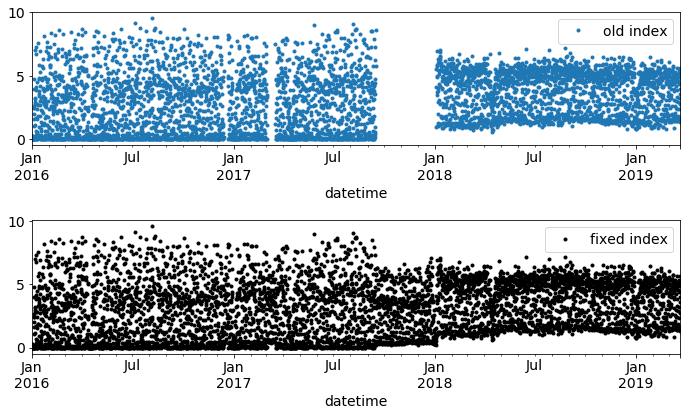

In [107]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
traffic_old['2016':'2019'].resample('5h').mean().plot(alpha=1,marker='.',linestyle='None',ax=ax[0])
ax[0].legend( ['old index'])
traffic.resample('5h').mean().plot(alpha=1,marker='.',linestyle='None',ax=ax[1],c='black')
ax[1].legend( ['fixed index'])

plt.tight_layout()

In [ ]:
bkkpm = bkkpm.merge(traffic,left_index=True,
                                    right_index=True, how='left' )

In [141]:
bkkpm['year'] = bkkpm.index.year
bkkpm['TimeofDay'] = bkkpm.index.hour

Text(0.5, 0, 'time of day')

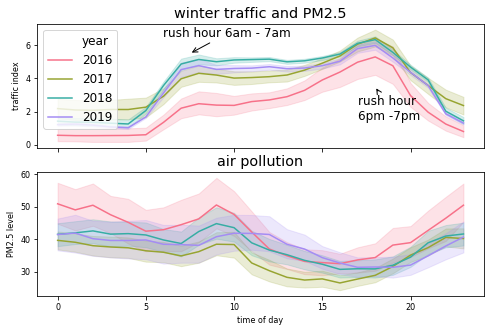

In [144]:
# traffic and time of day
fig,ax = plt.subplots(2,1, figsize=(8,5),sharex=True)
#set plt font size
plt.rcParams.update({'font.size': 12})


data = bkkpm.loc[bkkpm['season'].str.contains('winter')]

# plot the traffic index vs hour of day
sns.lineplot(data=data,x='TimeofDay',y='index',hue='year',
            palette=sns.color_palette("husl", 4),ax=ax[0])
ax[0].axes.set_ylabel('traffic index')
ax[0].set_title('winter traffic and PM2.5')

#add annotation
ax[0].annotate('rush hour 6am - 7am',xy=(7.5,5.5), xytext=(6, 6.5),
                arrowprops=dict(facecolor='black',arrowstyle='->'))

#add annotation
ax[0].annotate('rush hour \n6pm -7pm',xy=(18,3.5), xytext=(17, 1.5),
                arrowprops=dict(facecolor='black',arrowstyle='->'))

#plot PM2.5 
sns.lineplot(data=data,x='TimeofDay',y='PM2.5',hue='year',
            palette=sns.color_palette("husl", 4),ax=ax[1],legend=False)
ax[1].set_title('air pollution')
ax[1].axes.set_ylabel('PM2.5 level')
ax[1].axes.set_xlabel('time of day')

Traffic index may not be as useful, but hour of day is an equivalent features.

[go to Table of Content](#tbc)

# 3.Build a machine learning model<a id='ML'></a>

In [85]:
# load data
bkkpm_combo = pd.read_csv('data/model/bkkpm_combo_fireAR.csv')
bkkpm_combo.rename(columns={'Unnamed: 0':'datetime'},inplace=True)
bkkpm_combo['datetime'] = pd.to_datetime(bkkpm_combo['datetime'])
bkkpm_combo = bkkpm_combo.drop('weekofyear',axis=1)

to_cat = ['Wind']
for cat in to_cat:
    bkkpm_combo[cat] = bkkpm_combo[cat].astype('category')

bkkpm_combo.head(2)

,datetime,PM2.5,is_holiday,is_weekend,DayofWeek,hour,prev_level,Wind,Temperature(C),Humidity(%),Wind Speed(kmh),is_rain,fire0-240km,fire240km-480km,fire480km-720km,index
0,2016-03-04 16:00:00,35,0,0,4,16,44,SSW,33.89,46.0,14.48,0.0,1364,3632,101888,7.1
1,2016-03-04 17:00:00,30,0,0,4,17,42,SSW,33.89,46.0,12.87,0.0,1334,3606,101103,8.2


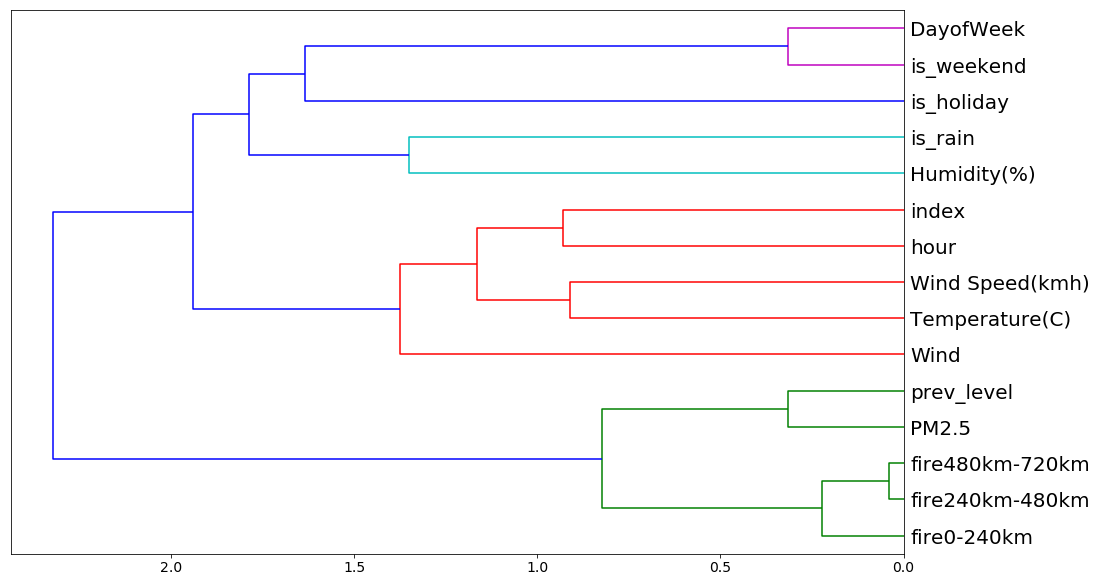

In [94]:
from scipy.cluster import hierarchy as hc

# Redundant Features
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(bkkpm_combo.drop('datetime',axis=1)).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=bkkpm_combo.columns, orientation='left', leaf_font_size=20)
plt.show()

The pollution level are highly correlated, then the fires and the weather features are further away.

In [287]:
print(bkkpm_combo['datetime'].min(), bkkpm_combo['datetime'].max())

2016-03-04 16:00:00 2019-03-20 20:00:00


In [288]:
bkkpm_combo.shape

(24430, 16)

 ## Training, validation, and test sets
 
 Time series data should not be randomly split since the model might learn from an example of data.

In [44]:
#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 18 catergory
df, y, nas = proc_df(bkkpm_combo, 'PM2.5',max_n_cat=18, skip_flds=['datetime'])

In [45]:
test_idxs = int(df.shape[0]*0.85)
X_test = df.iloc[test_idxs:]
y_test = y[test_idxs:]

val_idxs = int(df.shape[0]*0.85*0.75)

X_trn = df.iloc[:val_idxs]
y_trn = y[:val_idxs]

X_val = df.iloc[val_idxs:test_idxs]
y_val = y[val_idxs:test_idxs]

(array([735964., 736085., 736208., 736330., 736450., 736573., 736695., 736815., 736938., 737060., 737180.]),
 <a list of 11 Text xticklabel objects>)

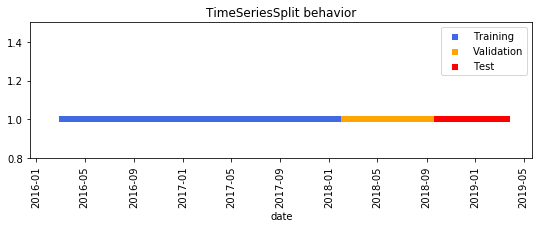

In [46]:
# Import and initialize the cross-validation iterator
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)
date = bkkpm_combo['datetime']

fig, ax = plt.subplots(figsize=(9, 2.5))
# Plot training and test indices
l1 = ax.scatter(date.iloc[X_trn.index], [1] * len(y_trn), c='royalblue', marker='_', lw=6)
l2 = ax.scatter(date.iloc[X_val.index], [1] * len(y_val), c='orange', marker='_', lw=6)
l3 = ax.scatter(date.iloc[X_test.index], [1] * len(y_test), c='red', marker='_', lw=6)
ax.legend([l1, l2, l3], ['Training', 'Validation','Test'])
ax.set(ylim=[0.8, 1.5], title='TimeSeriesSplit behavior', xlabel='date')
plt.xticks(rotation=90)

Use the training and validation set for hyper parameter tuning and feature selection.  Retrain the train+validation together and test on the test set. 

##  Extremely Randomized Trees

First, I tried RandomForestRegressor and found that it overfitted, so I asked TPOT auto ML library to search for the better model. It suggested ExtraTreesRegressor.  

In [43]:
m = ExtraTreesRegressor()
param_dist = {'n_estimators':range(20,200,20),
              'max_depth': [3, None],
              'min_samples_split' : [2, 5, 10], 
              'max_features' : range(2,5),
               'bootstrap' : [True, False],
              'min_samples_leaf': range(1, 8)}

#hyper parameter tuning
search = RandomizedSearchCV(m, param_distributions=param_dist,
                            n_iter=100,n_jobs=-1, cv=cv, random_state=42)

In [372]:
search.fit(X_trn,y_trn)
search.best_params_

{'n_estimators': 160,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 4,
 'max_depth': None,
 'bootstrap': False}

In [47]:
m = ExtraTreesRegressor(n_estimators=160, 
                          min_samples_split= 2,
                          min_samples_leaf= 3,
                          max_features= 4,
                          max_depth= None, 
                          bootstrap= False)

In [48]:
m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

[46.96848545237678, 50.31924978694888, 0.7511149662162994, 0.7024540100593624]


Feature of importance is based on permuting the feature and see how it affect the loss, here is mean square error.

In [13]:
# custom made feature of importance based on permutation method
def feat_importance(m, x_trn, y_trn, metric=mean_squared_error):
    """ Computes the feature importance for any model
    m is the model
    x_trn is the training data
    metric is the accuracy_score
    """
    baseline = metric(y_trn, m.predict(x_trn))
    imp = []
    imp_std = []
    for col in x_trn.columns:
        tempt = x_trn.copy()
        shuffle = []
        # ten iteration to get better statistic
        for i in range(10):
            tempt[col] = np.random.RandomState(seed=42).permutation(tempt[col])
            shuffle_score = metric(y_trn, m.predict(tempt))
            shuffle.append(-(baseline - shuffle_score)/baseline)
        imp.append(np.mean(shuffle))
        imp_std.append(np.std(shuffle))
    fea_imp = pd.DataFrame({'cols': x_trn.columns, 'imp':imp,'imp_std':imp_std})
    return fea_imp.sort_values('imp', ascending=False)

In [49]:
#Calculate feature of importance using my own feature of importance function
fi_per = feat_importance(m, X_val, y_val, mean_squared_error)
# normalize feature of importance
fi_per['imp'] = fi_per['imp']/fi_per['imp'].sum()

Text(0.5, 0, '% importance')

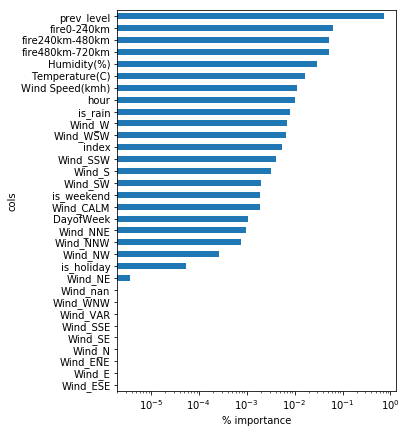

In [50]:
fi_per.plot('cols', 'imp', 'barh', legend=False,figsize=(5,7))
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('% importance')

In [51]:
# drop features with low importance 
# play around with the cut off to optimize the validation R2
to_drop = fi_per[fi_per.imp <0.003].cols

In [52]:
#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 18 catergory
df_drop = df.drop(to_drop,axis=1)

In [53]:
df_drop = df_drop.drop(['fire240km-480km','fire480km-720km'],axis=1)

In [54]:
test_idxs = int(df_drop.shape[0]*0.85)
X_test = df_drop.iloc[test_idxs:]
y_test = y[test_idxs:]

val_idxs = int(df_drop.shape[0]*0.85*0.75)

X_trn = df_drop.iloc[:val_idxs]
y_trn = y[:val_idxs]

X_val = df_drop.iloc[val_idxs:test_idxs]
y_val = y[val_idxs:test_idxs]

In [55]:
m = ExtraTreesRegressor(n_estimators=160, 
                          min_samples_split= 2,
                          min_samples_leaf= 3,
                          max_features= 4,
                          max_depth= None, 
                          bootstrap= False)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

[31.463474453702897, 36.28070955721233, 0.8332756990790688, 0.7854662045508198]


In [56]:
df_drop.columns

Index(['hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'is_rain', 'fire0-240km', 'index', 'Wind_S',
       'Wind_SSW', 'Wind_W', 'Wind_WSW'],
      dtype='object')

[31.46347 36.28071 83.64218  0.83328  0.78547  0.58403]


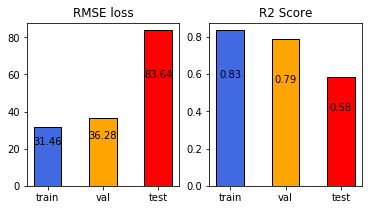

In [57]:
plot_score(m,res,val=True)

Model performance on the test set. 

**Visualize the model prediction**

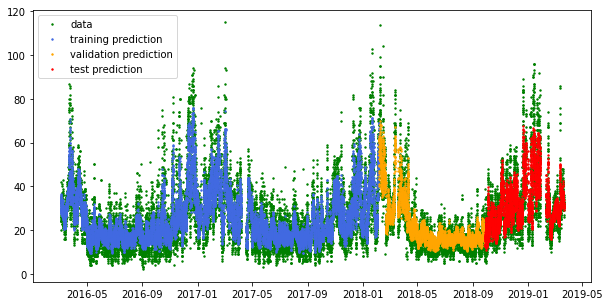

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
l1 = ax.scatter(x=date,y=y,c='green',s=2)
l2 = ax.scatter(x=date.iloc[:val_idxs],y=m.predict(X_trn),c='royalblue',s=2)
l3 = ax.scatter(x=date.iloc[val_idxs:test_idxs],y=m.predict(X_val),c='orange',s=2)
l4 = ax.scatter(x=date.iloc[test_idxs:],y=m.predict(X_test),c='red',s=2)

ax.legend([l1, l2, l3, l4], ['data', 'training prediction',
                         'validation prediction','test prediction'])


Retrain using the entire dataset. 

In [59]:
test_idxs = int(df_drop.shape[0]*0.85)
X_test = df_drop.iloc[test_idxs:]
y_test = y[test_idxs:]

X_trn = df_drop.iloc[:test_idxs]
y_trn = y[:test_idxs]

In [60]:
m = ExtraTreesRegressor(n_estimators=160, 
                          min_samples_split= 2,
                          min_samples_leaf= 3,
                          max_features= 4,
                          max_depth= None, 
                          bootstrap= False)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_test,y_test)

[27.771965195105306, 84.28350935964289, 0.8515255257840381, 0.580841664742]


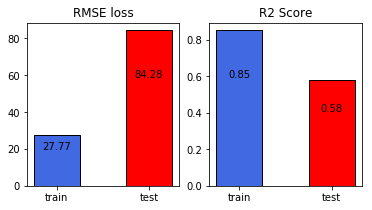

In [61]:
plot_score(m,res,val=False)

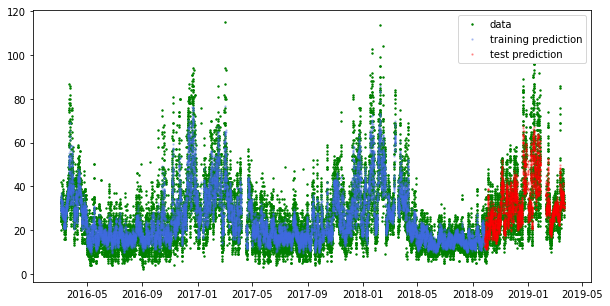

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
l1 = ax.scatter(x=date,y=y,c='green',s=2)
l2 = ax.scatter(x=date.iloc[:test_idxs],y=m.predict(X_trn),c='royalblue',s=2)
l4 = ax.scatter(x=date.iloc[test_idxs:],y=m.predict(X_test),c='red',s=2)

ax.legend([l1, l2, l4], ['data', 'training prediction','test prediction'])

The model tends to be closer to the mean. 

In [63]:
#Calculate feature of importance
fi_per = feat_importance(m, X_trn, y_trn, mean_squared_error)
# normalize feature of importance
fi_per['imp_std'] = fi_per['imp_std']/fi_per['imp'].sum()
fi_per['imp'] = fi_per['imp']/fi_per['imp'].sum()

Text(0.5, 1.0, 'feature of importance based on training set')

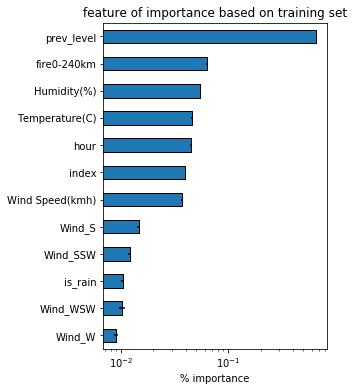

In [64]:
fi_per.plot('cols', 'imp', 'barh', xerr='imp_std' ,legend=False,figsize=(4,6),linewidth=1,edgecolor='black')
plt.ylabel(None)
plt.xlabel('% importance')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('feature of importance based on training set')

Pollution level from the previous hour is most important, but also the number of fires within 240 km distance, humidity and then traffic index, then wind direction. Reducing traffic will not solve the problem.

[go to Table of Content](#tbc)

# 4.Model Interpretation<a id='inter'></a>

- Select two examples of correctly predicted good/ bad air days
    - Jan 14, 2019 at 5am with PM2.5 = 66
    
- Use tree interpreter to look at contributions from each feature

In [65]:
from treeinterpreter import treeinterpreter as ti

In [66]:
predict = m.predict(X_test).round()

In [67]:
idxs_correct = np.greater_equal(y_test*1.1,predict)&np.greater_equal(predict,y_test*0.9)
correctpred = X_test.iloc[idxs_correct].copy()
correctpred['y_test'] = y_test[idxs_correct]
correctpred['prediction'] = predict[idxs_correct]
correctpred.loc[[correctpred['y_test'].idxmax(),correctpred['y_test'].idxmin()],:]

,hour,prev_level,Temperature(C),Humidity(%),Wind Speed(kmh),is_rain,fire0-240km,index,Wind_S,Wind_SSW,Wind_W,Wind_WSW,y_test,prediction
23148,3,69,26.11,83.0,0.00,0.0,151,1.3,0,0,0,0,73,66.0
20769,3,12,28.89,89.0,4.83,0.0,33,1.4,1,0,0,0,11,12.0


Tree interpreter takes the models and the value of each features and calculate the contribution to the final prediction.

In [68]:
# select the worse and the best day during the test periods 
idxmax = correctpred['y_test'].idxmax()
rowmax = X_test.loc[idxmax].values
prediction, bias, contributions = ti.predict(m, rowmax.reshape(1, -1))

In [69]:
# make a bias row, the starting point 
bias_df = pd.DataFrame({'feature':'bias','value':bias[0],'contribution':bias[0]},index =[0])
bias_df = bias_df.set_index('feature')

# build model interpredation df 
inter_df = pd.concat([pd.DataFrame(X_test.loc[idxmax]).reset_index(),pd.Series(contributions[0])],
           ignore_index=True,axis=1)
inter_df.columns = ['feature','value','contribution']
inter_df = inter_df.set_index('feature')
#order by feature of importance
inter_df = inter_df.reindex(fi_per.cols)
inter_df = pd.concat([bias_df,inter_df],axis=0,sort=False)
inter_df['predict_value'] = inter_df['contribution'].rolling(15,min_periods=0).sum()

In [70]:
inter_df = inter_df.round(2)
inter_df

,value,contribution,predict_value
bias,24.37,24.37,24.37
prev_level,69.00,30.81,55.18
fire0-240km,151.00,3.72,58.90
Humidity(%),83.00,1.08,59.98
Temperature(C),26.11,2.05,62.03
hour,3.00,1.36,63.38
index,1.30,-0.43,62.95
Wind Speed(kmh),0.00,1.86,64.81
Wind_S,0.00,0.63,65.44
Wind_SSW,0.00,0.28,65.72


### Visualize Model Prediction on a Bad Air Day

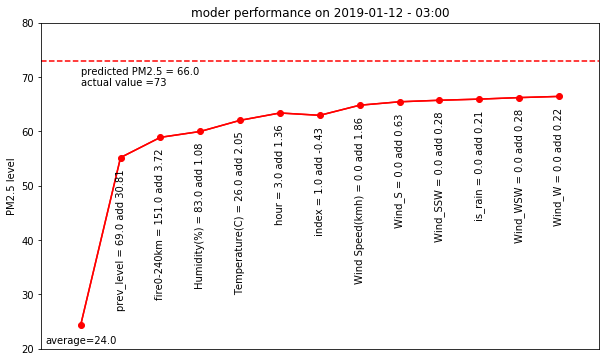

In [75]:
##visualize model prediction 
fig,ax = plt.subplots(figsize=(10,6))
# plot the model interpretation line
inter_df['predict_value'].plot(color='red')
inter_df['predict_value'].plot(marker='o',color='red')
plt.xticks([])
plt.ylabel('PM2.5 level')
plt.xlim(-1,len(inter_df))
plt.ylim(20,80)
plt.title('moder performance on ' + date.loc[idxmax].strftime('%Y-%m-%d - %H:%M'))

actual_value = correctpred.loc[idxmax,'y_test']
predict_value = correctpred.loc[idxmax,'prediction']

#add actual value line
plt.axhline(y=actual_value, color='r', linestyle='--')
plt.text(x=0, y=actual_value-1, s= f'predicted PM2.5 = {predict_value}\nactual value ={actual_value}',verticalalignment='top')


# add addnotation
for i in range(0,len(inter_df)):
    
    y_loc = inter_df.iloc[i].predict_value 
    value = inter_df.iloc[i].value.round(0)
    contri = inter_df.iloc[i].contribution.round(2)
    if i ==0:
        plt.text(x=i,y=y_loc-2,s= f'average={value}',horizontalalignment='center',verticalalignment='top')
    else:
        plt.text(x=i,y=y_loc-2,s= inter_df.index[i]+f' = {value} add {contri}',horizontalalignment='center',verticalalignment='top', rotation=90)

In [76]:
# select the worse and the best day during the test periods 
idxmin = correctpred['y_test'].idxmin()
rowmin = X_test.loc[idxmin].values
# construct tree interpretation value
prediction, bias, contributions = ti.predict(m, rowmin.reshape(1, -1))

# make a bias row, the starting point 
bias_df = pd.DataFrame({'feature':'bias','value':bias[0],'contribution':bias[0]},index =[0])
bias_df = bias_df.set_index('feature')

# build model interpredation df 
inter_df = pd.concat([pd.DataFrame(X_test.loc[idxmin]).reset_index(),pd.Series(contributions[0])],
           ignore_index=True,axis=1)
inter_df.columns = ['feature','value','contribution']
inter_df = inter_df.set_index('feature')

#order by feature of importance
inter_df = inter_df.reindex(fi_per.cols)
inter_df = pd.concat([bias_df,inter_df],axis=0,sort=False)
inter_df['predict_value'] = inter_df['contribution'].rolling(15,min_periods=0).sum()

### Visualize Model Prediction on a Good Air Day

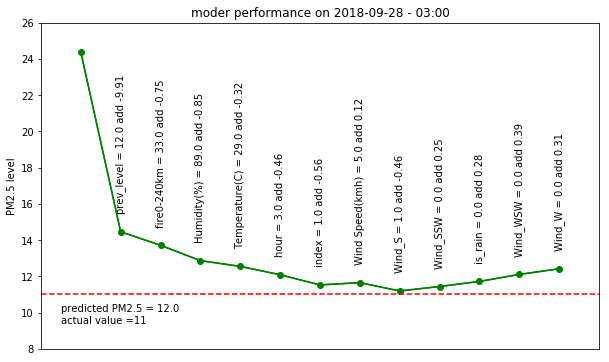

In [80]:
##visualize model prediction 
fig,ax = plt.subplots(figsize=(10,6))
# plot the model interpretation line
inter_df['predict_value'].plot(color='green')
inter_df['predict_value'].plot(marker='o',color='green')
plt.xticks([])
plt.ylabel('PM2.5 level')
plt.xlim(-1,len(inter_df))
plt.ylim(8,26)
plt.title('moder performance on ' + date.loc[idxmin].strftime('%Y-%m-%d - %H:%M'))


actual_value = correctpred.loc[idxmin,'y_test']
predict_value = correctpred.loc[idxmin,'prediction']

#add actual value line
plt.axhline(y=actual_value, color='r', linestyle='--')
plt.text(x=-0.5, y=actual_value-0.5, s= f'predicted PM2.5 = {predict_value}\nactual value ={actual_value}',verticalalignment='top')

# add addnotation
for i in range(1,len(inter_df)):
    y_loc = inter_df.iloc[i].predict_value 
    value = inter_df.iloc[i].value.round(0)
    contri = inter_df.iloc[i].contribution.round(2)
    plt.text(x=i,y=y_loc+1,s= inter_df.index[i]+f' = {value} add {contri}',horizontalalignment='center',verticalalignment='bottom', rotation=90)


# Summary

In summary, 
- Study effect of  weather, fire spots, traffic on air pollution.
- Use ExtraTreeRegressor to identify features most contribute to the air pollution level in Bangkok. 
- Most important feature are fires from agricultural burning in winter season.
- The model still achieve about 0.58 - 0.78 R-squared on the validation and test set. 

The fact that there are complex interaction amount features. The level of influence of the fire depends on the wind direction and wind speed suggest that using a neural network maybe a better approach. This will be the subject of future work. 

[go to Table of Content](#tbc)